# SpykProps

This Jupyter notebook is an overview of the main functions from `SpykProps`. 

*Author: Joan Barreto Ortiz (jbarreto@umn.edu)*

**Load libraries**

In [1]:
import SpykFunctions as SF
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.dpi']= 200
plt.rcParams["axes.grid"] = False

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


**List files**

In [2]:
images_path = r'./Images'
Images = SF.ListImages(images_path, imgformat=".tif", recursive=False)

**Read and visualize an image**

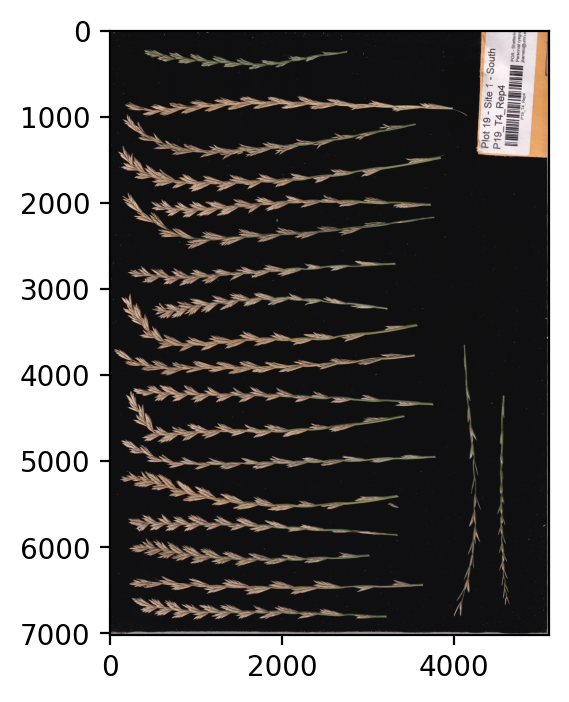

In [3]:
img = plt.imread(Images[1])
plt.imshow(img)

# Spike Segmentation

This function takes an image array (or path to image) and outputs a list with segmented spikes (masks). 

There are two methods for spike segmentation:
- **Otsu**: estimates the threshold on a gray image using Otsu's algorithm. It requires a scaling parameter (`OtsuScaling`) from zero (no threshold) to one (no scaling) for the estimated threshold.
- **Color thresholding**: requires a list with the channel and threshold to segment the spike. E.g. `channel_thresh=[0,30]` keeps pixel values greater than 30 on the 0th (red) channel. 

Images can be resized using the `rescale_rgb` parameter. E.g. `rescale_rgb=0.5` resizes both the horizontal and vertical axes by half. Rescaling values lower than 0.5 may affect spikelet segmentation.

The parameters with the suffix `_out` specify which masks will be appended to the output `I`, which is a list.

The parameter `crop_coord` takes a list with coordinates to crop the images if required.


## Full image
Segments all spikes in original image. 


CPU times: user 8.24 s, sys: 2.22 s, total: 10.5 s
Wall time: 6.29 s


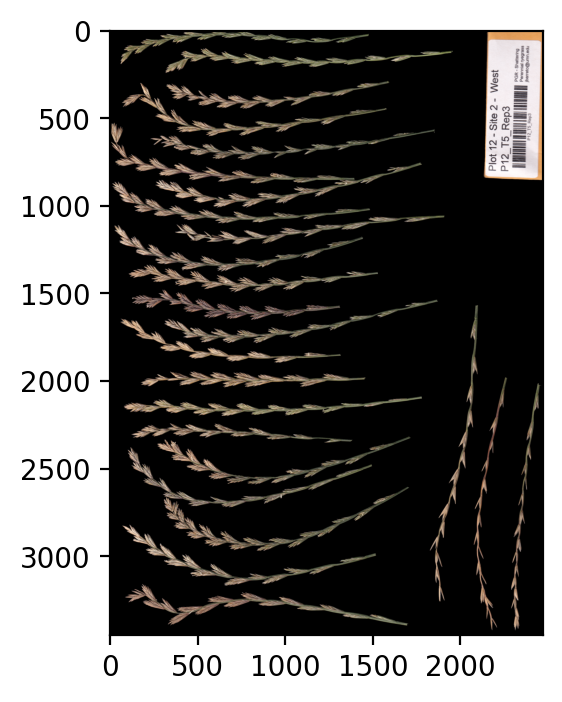

In [65]:
%%time

I = SF.spike_segm(Images[0], rescale_rgb=0.5, channel_thresh=[0,30], rgb_out=True, 
               gray_out=True, lab_out=True, hsv_out=True, bw_out=True,
              crop_coord=[44,6940,25,4970])
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]

plt.imshow(rgb0)

### Enumerate spikes

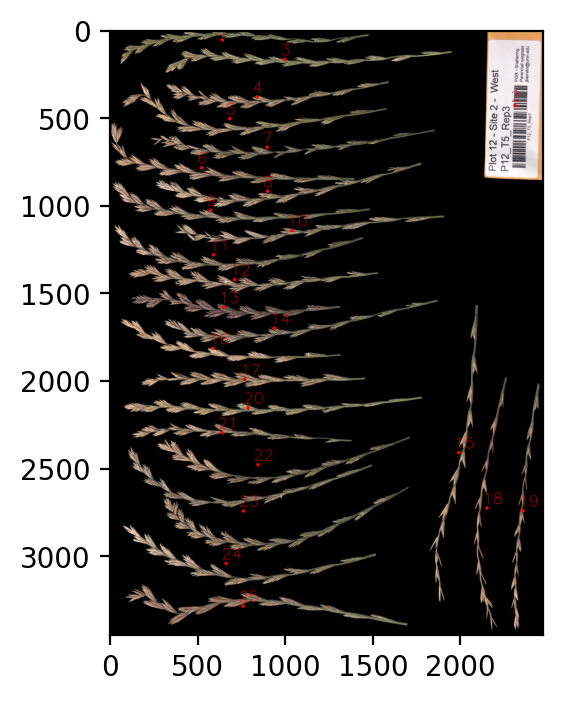

In [66]:
SF.EnumerateSpkCV(bw0, rgb0, TextSize=None, Plot=True, PlotOut=False)

## Single spike
Select an area for a particular spike

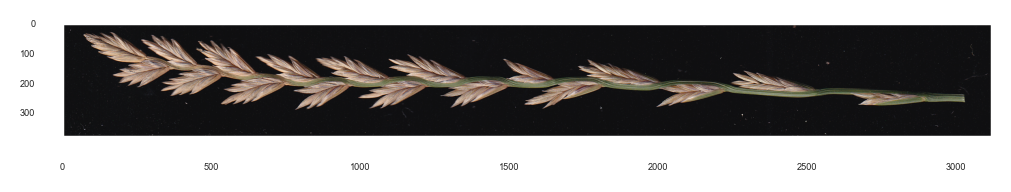

In [155]:
# img0 = img[3000:4100, 10:3700, :]  # Three horizontal spikes
img0 = img[6550:6930, 180:3300, :]     # Single horizontal spike
# img0 = img[3500:6930, 3900:4400, :]    # Single vertical spike

plt.imshow(img0)

### Otsu
Sccaling by 30% (`OtsuScaling=0.3`)

CPU times: user 1.15 s, sys: 398 ms, total: 1.55 s
Wall time: 557 ms


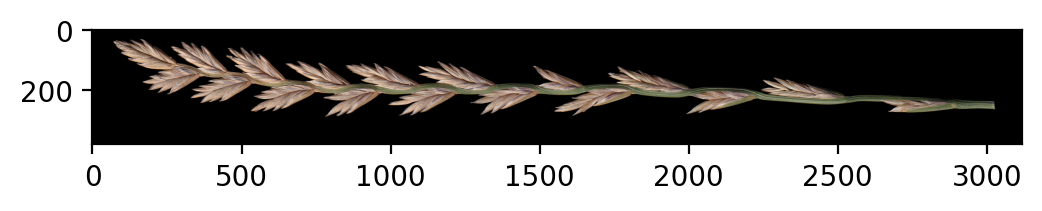

In [8]:
%%time

I = SF.spike_segm(img0, OtsuScaling=0.3, rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]

plt.imshow(rgb0)

### Channel-Threshold 
Keep pixel values greater than 30 on the 0th (red) channel.

CPU times: user 1.02 s, sys: 243 ms, total: 1.26 s
Wall time: 390 ms


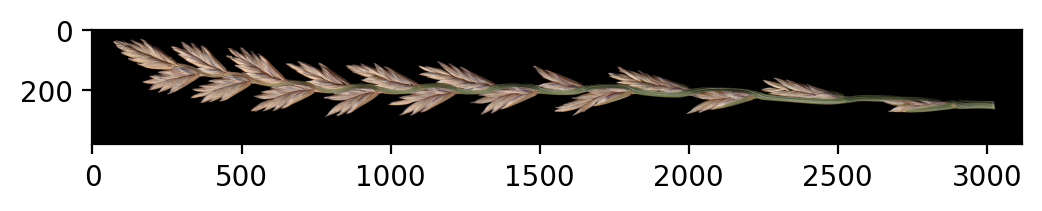

In [9]:
%%time
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]

plt.imshow(rgb0)

# Color distribution across spikes

The function `PixelHist` allows to see the distribution of pixel values across spikes for a given channel.

The function requires a binary mask (`bw`), colored mask (`ColorSpace`), and the channel (`channel`) to evaluate. The spikes (`spikes`) can be specified with a list. The output is an overlapping histogram per spikes. The number of bin (`nbins`) can be specified.

## Subset, segment, and enumerate spikes

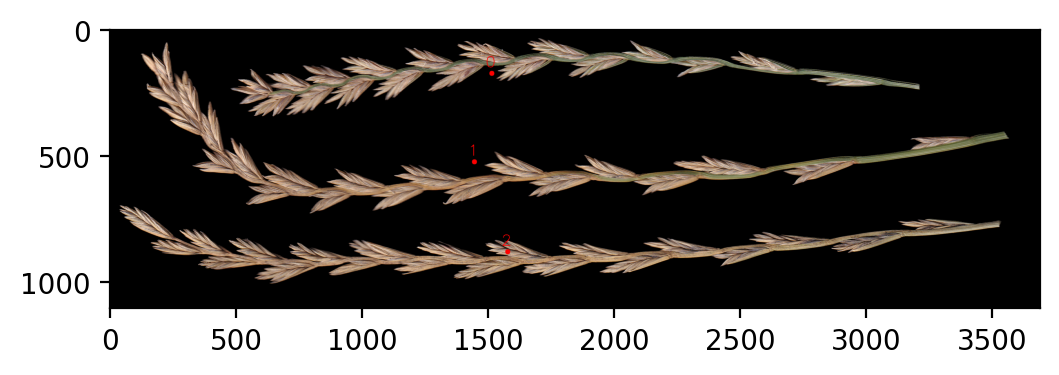

In [4]:
# Subset
img0 = img[3000:4100, 10:3700, :]  # Three horizontal spikes
# plt.imshow(img0)

# Segmentation
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]
# plt.imshow(rgb0)

# Enumerate
SF.EnumerateSpkCV(bw0, rgb0, TextSize=None, Plot=True, PlotOut=False, BaseZero=True)

## Plot pixel-values distributions
The example below shows the distribution of 'a' values (a green-to-red scale from the CIELab scale) for spikes 0 (red), 1 (green), and 2 (blue). The inserted box shows the spike's area and its mean intensity value for the given channel.



In [143]:
bw = bw0; ColorSpace = hsv0; channel =0; spikes=[1,2]; nbins = 100

labeled_spks, num_spikes = label(bw, return_num = True)

Props = regionprops(labeled_spks, intensity_image=ColorSpace[:,:,channel])
Areas = [rp.area for rp in Props]
Labels = [rp.label for rp in Props] #Delete 1 because label in image is +1 greater than ACTUAL label
Spikes_Data = []
Names = []
Colors = sns.color_palette("husl", len(spikes))
Colors2 = [list(i) for i in Colors] # list of lists

for indexed in range(len(Labels)):
    spk_data = Props[indexed].intensity_image
    spk_data = spk_data.ravel()
    NonZero = spk_data[spk_data != 0]

    Spikes_Data.append(NonZero)
    Names.append("Spike " + str(indexed) + "\n" 
                 + "Area = "  + str(round(np.mean(NonZero))) + " px" 
                 + "\n" + "Mean = "  + str(round(np.mean(NonZero), 1)))

['Spike 0\nArea = 0 px\nMean = 0.2',
 'Spike 1\nArea = 0 px\nMean = 0.1',
 'Spike 2\nArea = 0 px\nMean = 0.2']

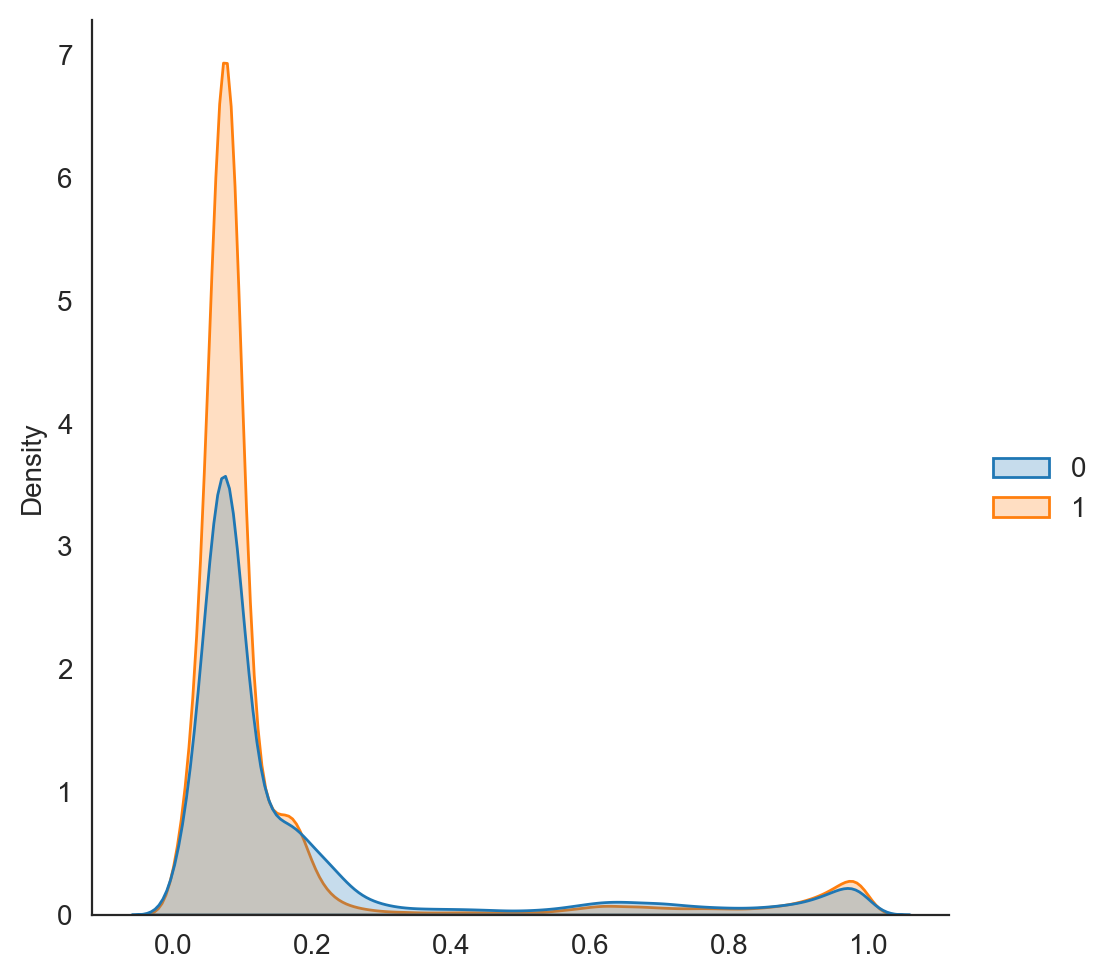

In [144]:
Names
sns.set_style("white")
sns.displot(Spikes_Data, kind="kde",fill=True)

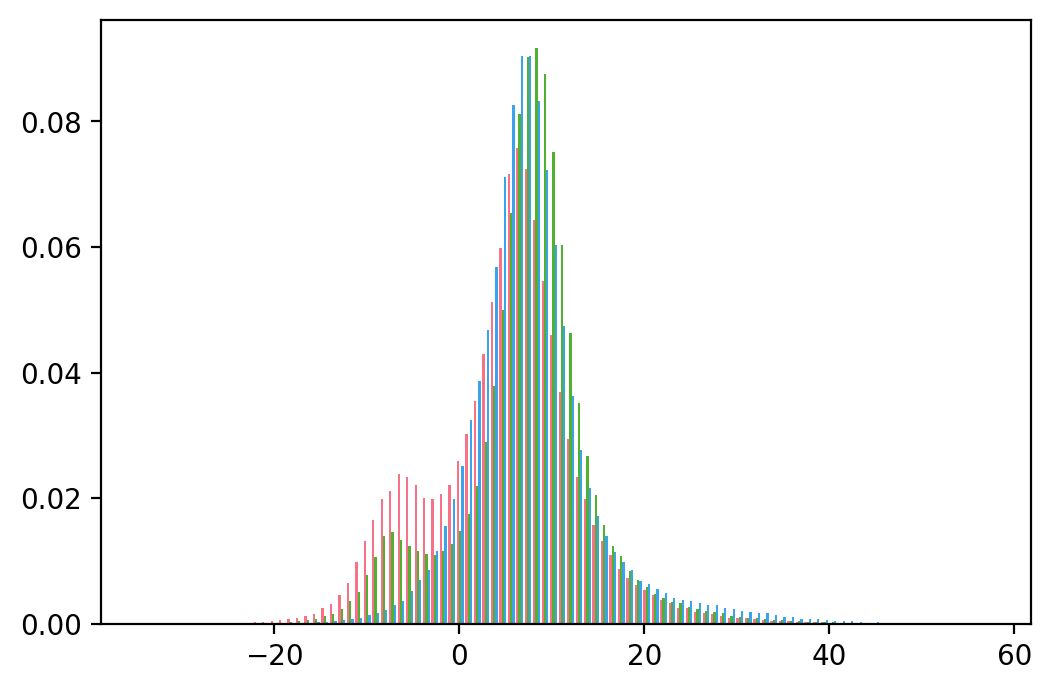

In [56]:
plt.hist(Spikes_Data, bins = nbins, color = Colors2, label = Names, density=True);

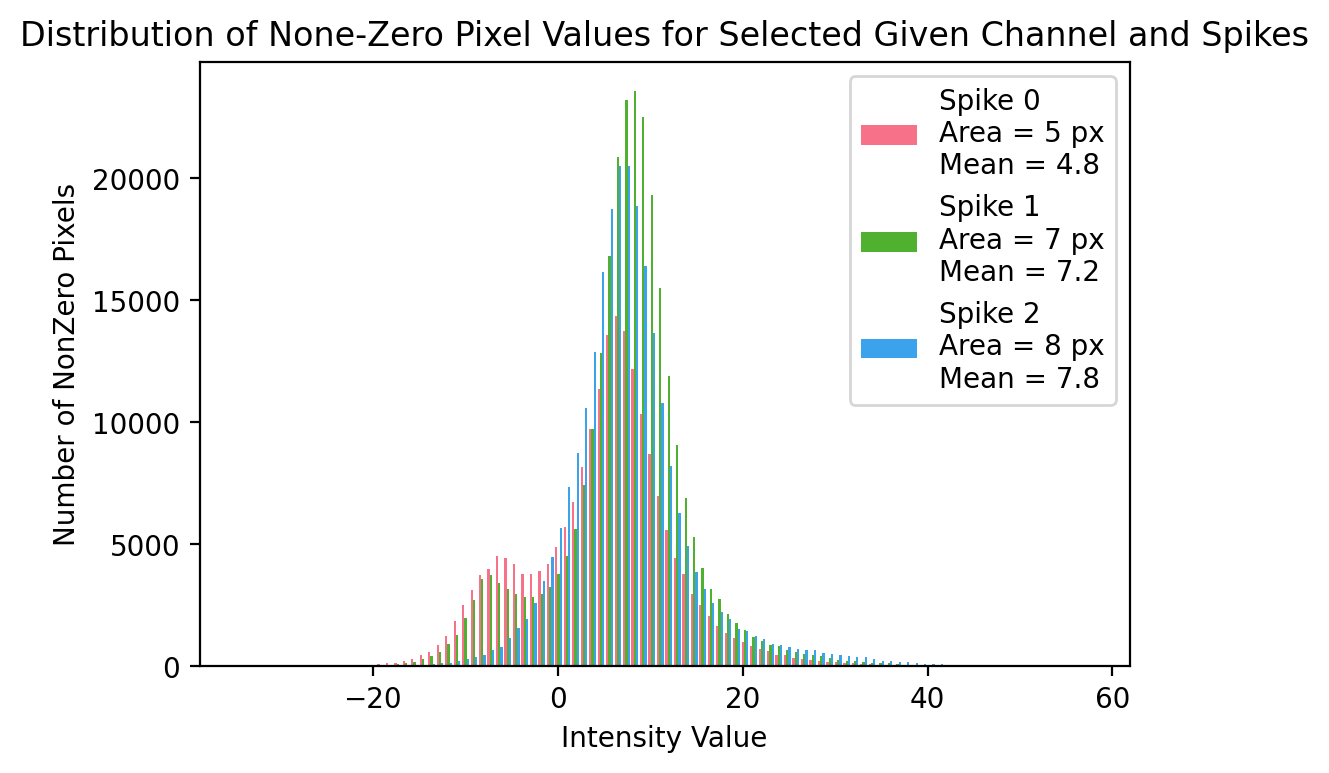

In [6]:
SF.PixelHist(bw=bw0, ColorSpace=lab0, channel = 1, spikes=[0,1,2], nbins = 100)

# Spike Length

This function takes a spike's binary mask and approximates its length given a method. The `Method` options include bounding box (`bbox`), convex hull (`chull`), and the two current skeletonization methods available by *scikit-image*'s `skeletonize` function (see https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.skeletonize). The medial axis method (`skel_ma`) is more accurate but also more computationally intensive. 

## Single method

The two outputs are 
- an integer with the length in pixels, and
- an image object with the overlay (if `Overlay=True` and `Method` is either `'skel'` or `'skel_ma'`)

In [12]:
img0 = img[6550:6930, 180:3300, :]     # Single horizontal spike

# Segmentation
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
bw0 = I[4]

# Spike length
SL, length_img = SF.spk_length(bw0, Method='skel_ma', Overlay=True)

print("This spike's length is", SL, "pixels.")

This spike's length is 2864 pixels.


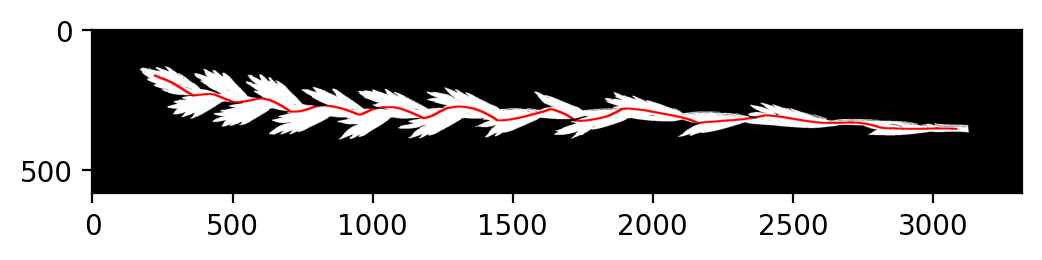

In [13]:
plt.imshow(length_img)

### Zhang's algorithm

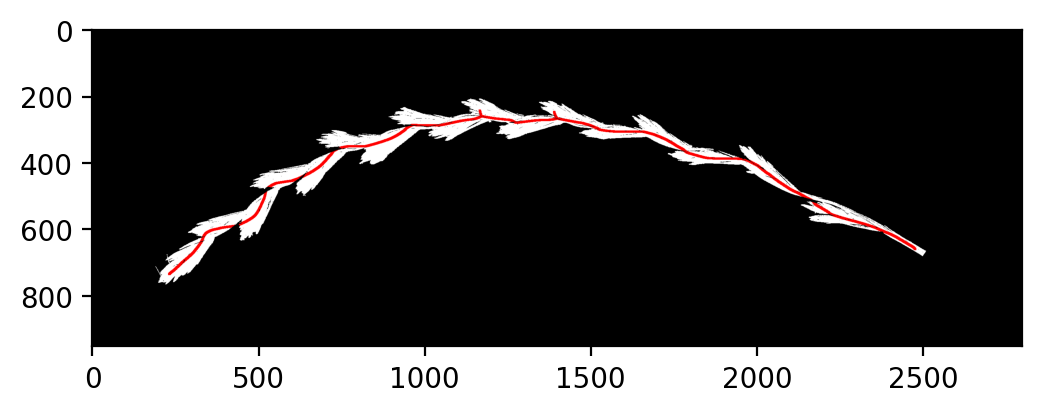

In [14]:
images_path = r'./Images/TEST/Test'
Images = SF.ListImages(images_path, imgformat=".tif", recursive=False)

img = plt.imread(Images[0])
img0 = img[200:950, 700:3300, :]     # Single horizontal spike
# plt.imshow(img0)

# Segmentation
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
bw0 = I[4]

# Spike length
SL, length_img = SF.spk_length(bw0, Method='skel', Overlay=True)

plt.imshow(length_img)


### Medial axis

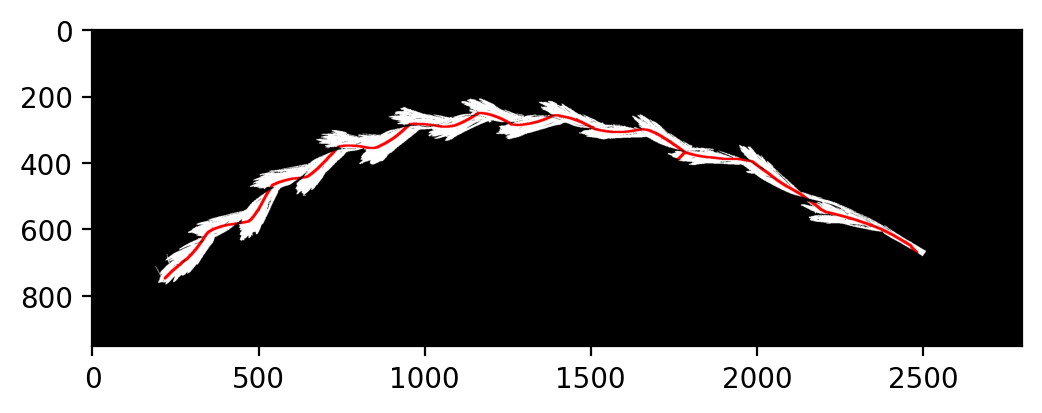

In [15]:
# Segmentation
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
bw0 = I[4]

# Spike length
SL, length_img = SF.spk_length(bw0, Method='skel_ma', Overlay=True)

plt.imshow(length_img)

### Ellipse's major axis

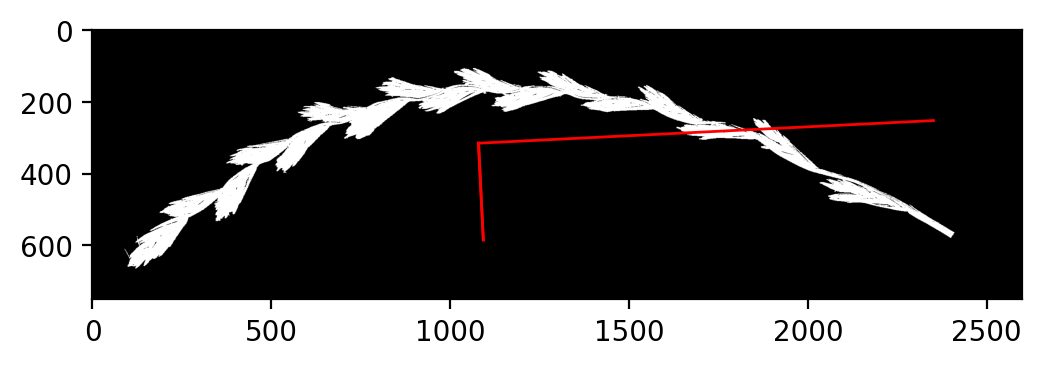

In [11]:
import math
from skimage.measure import label, regionprops, regionprops_table

label_img = label(bw0)
regions = regionprops(label_img)

fig, ax = plt.subplots()
ax.imshow(bw0, cmap=plt.cm.gray)

for props in regions:
    y0, x0 = props.centroid
       
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)
    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=1)

plt.show()

In [ ]:
# Approach 1: labeled image
markers, spikelets = ndi.label(bw0)

In [101]:
import cv2
import numpy as np

bw1 = np.uint8(bw0) * 255
ret,thresh = cv2.threshold(bw1,150,255,0)
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = np.squeeze(contours)
cnt = contours[0]
ellipse = cv2.fitEllipse(cnt)

# Ell_plot = cv2.ellipse(thresh,ellipse, (255,0,255), 3)


210.284912109375 -3153.860107421875 4181.19140625 4181.19140625 0.0
90.0


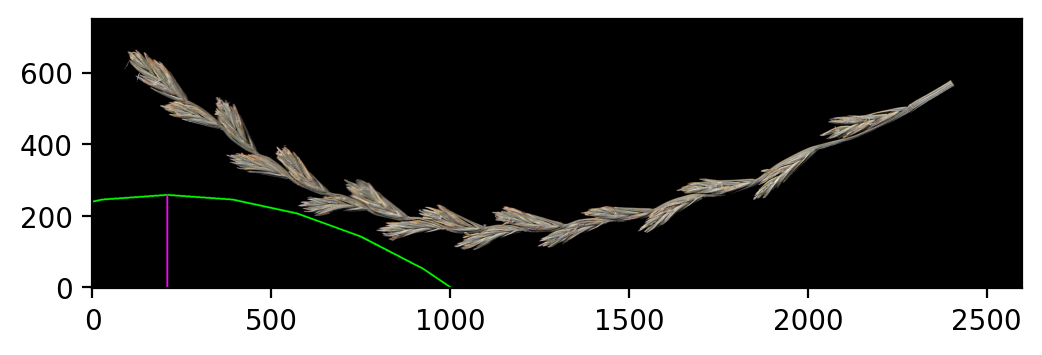

In [110]:
(xc,yc),(d1,d2),angle = ellipse
print(xc,yc,d1,d1,angle)

# draw ellipse
result = I[0].copy()
result = cv2.ellipse(result, ellipse, (0, 255, 0), 3)

# draw circle at center
xc, yc = ellipse[0]
result = cv2.circle(result, (int(xc),int(yc)), 10, (255, 255, 255), -1)

# draw vertical line
# compute major radius
rmajor = max(d1,d2)/2
if angle > 90:
    angle = angle - 90
else:
    angle = angle + 90
print(angle)
xtop = xc + math.cos(math.radians(angle))*rmajor
ytop = yc + math.sin(math.radians(angle))*rmajor
xbot = xc + math.cos(math.radians(angle+180))*rmajor
ybot = yc + math.sin(math.radians(angle+180))*rmajor

result = cv2.line(result, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (255, 0, 255), 3)

plt.imshow(result, origin='lower')
plt.show()
# plt.gca().invert_yaxis()

In [98]:
ellipse

((210.284912109375, -3153.860107421875),
 (4181.19140625, 6825.94384765625),
 0.0)

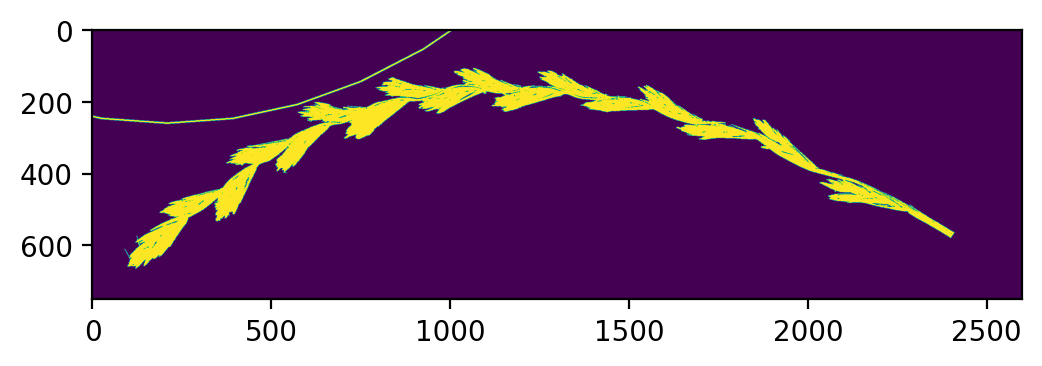

In [99]:
# Ell_plot = cv2.ellipse(thresh,ellipse, (255,0,255), 3)
plt.imshow(Ell_plot)
plt.show()


### Convex hull's major axis

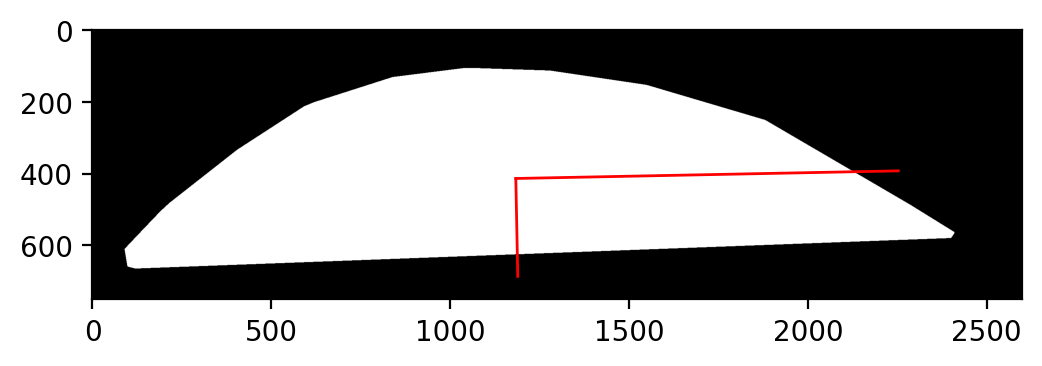

In [135]:
from skimage.morphology import convex_hull_image

chull = convex_hull_image(bw0)
label_chull = label(chull)
chull_regions = regionprops(label_chull)

fig, ax = plt.subplots()
ax.imshow(chull, cmap=plt.cm.gray)

for props in chull_regions:
    y0, x0 = props.centroid
       
    orientation = props.orientation
    x1 = x0 + math.cos(orientation) * 0.5 * props.minor_axis_length
    y1 = y0 - math.sin(orientation) * 0.5 * props.minor_axis_length
    x2 = x0 - math.sin(orientation) * 0.5 * props.major_axis_length
    y2 = y0 - math.cos(orientation) * 0.5 * props.major_axis_length

    ax.plot((x0, x1), (y0, y1), '-r', linewidth=1)
    ax.plot((x0, x2), (y0, y2), '-r', linewidth=1)


plt.show()

## All methods

`Method='all'` requires `Overlay=False`, and returns:
- a dataframe with the lengths across methods
- a dataframe with the time to compute each method

The lengths can also be computed in batch using the `LengthBatch()` function, which only requires a path to the images.

In [5]:
Lengths,Time = SF.spk_length(bw0, Method='all', Overlay=False)

### Lengths

In [6]:
Lengths

,bbox,chull,skel_Lee,skel
0,3054.0,2949.0,2859.0,3143.0


### Time

In [7]:
Time

,bbox,chull,skel_Lee,skel
0,0.03,0.33,0.64,0.45


# Elliptical Fourier Descriptors

The `efd` function tales a binary mask of a spike as input and returns the Elliptical Fourier descriptors (efd), using the `spatial_efd` package (see https://pypi.org/project/spatial-efd/).

While the number of harmonics (`n_harmonics`) is required, `efd` also returns the maximum number of harmonics that can be computed for a given contour (Nyquist Frequency), as the last variable in the resulting dataframe.

If `efd_filename` is specified, the plot with the outline will be saved as a .png file with the same name, followed by an underscore and the number of harmonics. E.g. if `efd_filename='./EFD_plot'` and `n_harmonics=30`, the plot will be saved as './EFDplot_30.png'. If the `efd_filename=None`, the plot will be returned in the console.


CPU times: user 958 ms, sys: 277 ms, total: 1.24 s
Wall time: 1.23 s


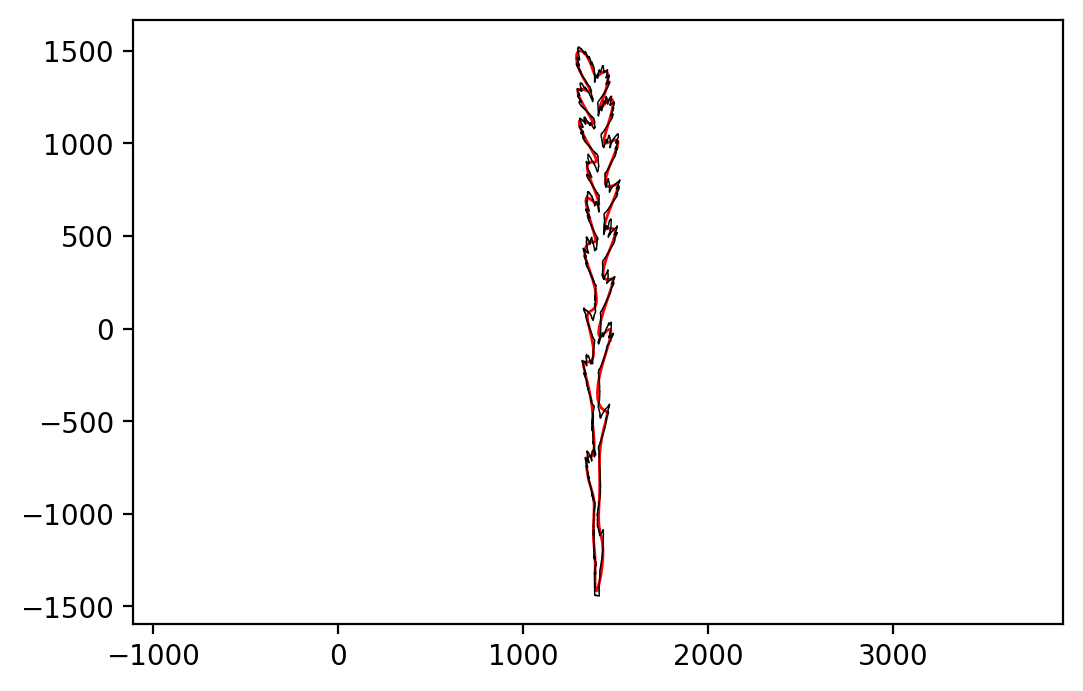

In [15]:
%%time
efd_data = SF.efd(bw0, n_harmonics=30, plot_efd=True, efd_filename=None)

In [16]:
efd_data

,An1,Bn1,Cn1,Dn1,An2,Bn2,Cn2,Dn2,An3,Bn3,...,Dn28,An29,Bn29,Cn29,Dn29,An30,Bn30,Cn30,Dn30,Min_Coeffs
0,1.0,-7.853388e-18,1.884813e-17,0.051959,-0.133648,0.020026,-0.017005,0.011499,0.126568,-0.024768,...,-0.000531,-0.003677,0.004106,-0.001395,0.001638,0.001787,-0.003882,-0.001194,-0.001058,81


# Spikes dataframe
The function `SpikesDF` requires the list of masks returned by the `spike_segm`  function, and the image's path. The output is a dataframe with the image name, spike ID, and both geometric (except for length and EFD) and color properties.

In [10]:
%%time

# Subset
img0 = img[3000:4100, 10:3700, :]  # Three horizontal spikes

# Spike segmentation
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]

# Enumerate
# SF.EnumerateSpkCV(bw0, rgb0, TextSize=None, Plot=True, PlotOut=False, BaseZero=True)

df = SF.SpikesDF(I=I, ImagePath='image_path')
df

CPU times: user 4.15 s, sys: 1.08 s, total: 5.23 s
Wall time: 2.81 s


,Image_Name,Spike_Label,Red_mean,Red_min,Red_max,Green_mean,Green_min,Green_max,Blue_mean,Blue_min,...,Orientation,Eccentricity,Perimeter,EquivDiams,Extents,Ferets,InertiaTensors,PerimCroftons,Soliditys,Circularity
0,image_path,1,147.915583,31.0,255.0,128.329337,0.0,255.0,108.638655,0.0,...,-1.529619,0.996936,16460.405907,513.390201,0.245035,2734.014813,"[[502039.8754138266, 20557.708244514564], [205...",15406.338488,0.383294,0.009601
1,image_path,2,153.080702,31.0,255.0,126.136222,0.0,255.0,101.605819,0.0,...,1.530198,0.991533,16042.213952,597.894038,0.120417,3459.965318,"[[917352.4911857876, -36634.19193525828], [-36...",15034.235142,0.206909,0.013709
2,image_path,3,154.013091,31.0,255.0,126.379662,0.0,255.0,102.939415,0.0,...,-1.554719,0.998460,21104.869253,561.608719,0.229247,3497.416904,"[[878166.955655315, 14076.556184142646], [1407...",19179.780902,0.339831,0.006989


The following standarizes each variable across spikes and retuns a heatmap to visualize their differences.

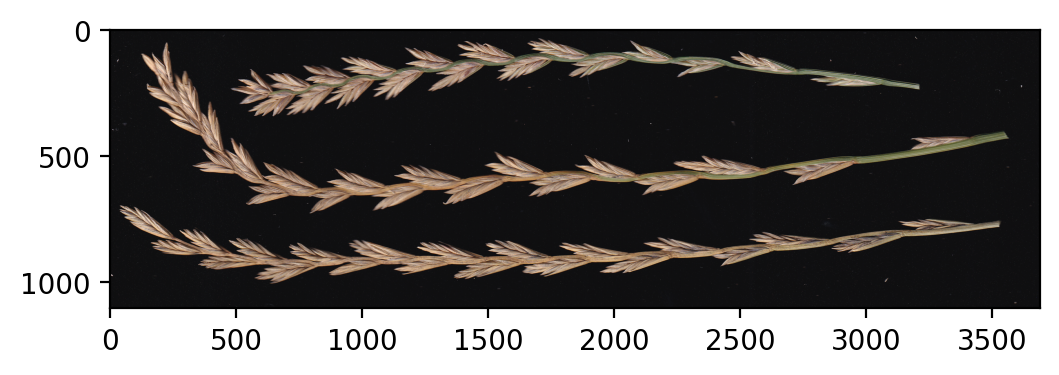

In [5]:
plt.imshow(img0)

(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, '1'), Text(0, 1.5, '2'), Text(0, 2.5, '3')])

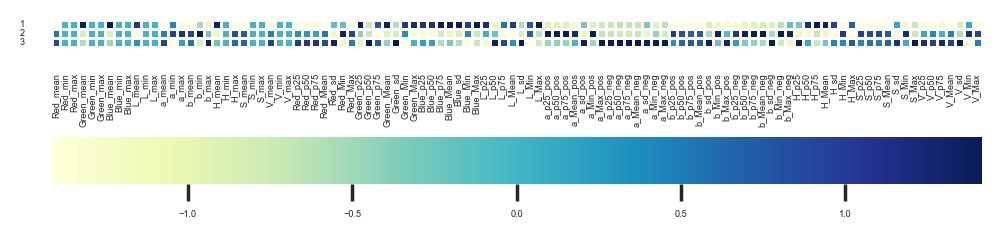

In [11]:
df_std = df.iloc[:,2:106]
scaler = StandardScaler()
x_scaled = scaler.fit_transform(df_std)
df_std = pd.DataFrame(x_scaled, columns=df.columns[2:106], index=df.index)

sns.set(font_scale=0.3)
ax = sns.heatmap(df_std, linewidths=.5,
                 cmap='YlGnBu',
                 xticklabels=list(df_std.columns),
                 yticklabels=df.Spike_Label,
                 cbar_kws={"orientation": "horizontal"})
plt.yticks(rotation=0) 
ax.set_aspect("equal")

In [10]:
df_std.columns


Index(['Red_mean', 'Red_min', 'Red_max', 'Green_mean', 'Green_min',
       'Green_max', 'Blue_mean', 'Blue_min', 'Blue_max', 'L_mean',
       ...
       'S_sd', 'S_Min', 'S_Max', 'V_p25', 'V_p50', 'V_p75', 'V_Mean', 'V_sd',
       'V_Min', 'V_Max'],
      dtype='object', length=104)

# Spikelet Segmentation

This function takes an RGB mask for a single spike and outputs, respectively:
- a labeled image with the detected spikelets, 
- geometric properties of fitted ellipses per spike, and 
- an image of the fitted ellipses and the estimated spikelet's angle.

Adding a pad around the spike improves spikelet segmentation. For spikes from the original 7016x5104 (length x width) images, `Pad=200` works well.

The `MinDist` argument refers to the expected minimum distance (in pixels) between spikelets. For 7016x5104 (length x width) images, `MinDist=50` seems to work well overall. For images rescaled to 0.5 and 0.75, `MinDist=40` was better.

`data_out=True` returns a dataframe with the ellipses' ID, Angle (approximation of spikelet angle), Area, Length, and centroid. `plot_ellipse=True` returns an image of the spike with the fitted ellipses and angles, each with a different color, and adds the ID number if `Numbered=True`. The image can be printed is returned to the console (`img_out=False`) or as an object in the Python environment (`img_out=True`). To visually assess the watershed segmentation, the previous image parameters must be set to `False` and `plot_segmented=False`.



In [54]:
plt.rcParams["axes.grid"] = False

# subset single spike
img0 = img[6550:6930, 180:3300, :] 

# Spike segmentation
I = SF.spike_segm(img, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
rgb0 = I[0]
gray0 = I[1]
lab0 = I[2]
hsv0 = I[3]
bw0 = I[4]

# Spikelet segmentation
Spikelets,EllipseData,Spikelets_Image = SF.spikelet_segm(cropped_rgb=rgb0,Pad=200,MinDist=50,data_out=True,
                            plot_ellipse=True,Numbered=True,img_out=True,plot_segmented=False)

Error! Check spike segmentation!


TypeError: cannot unpack non-iterable NoneType object

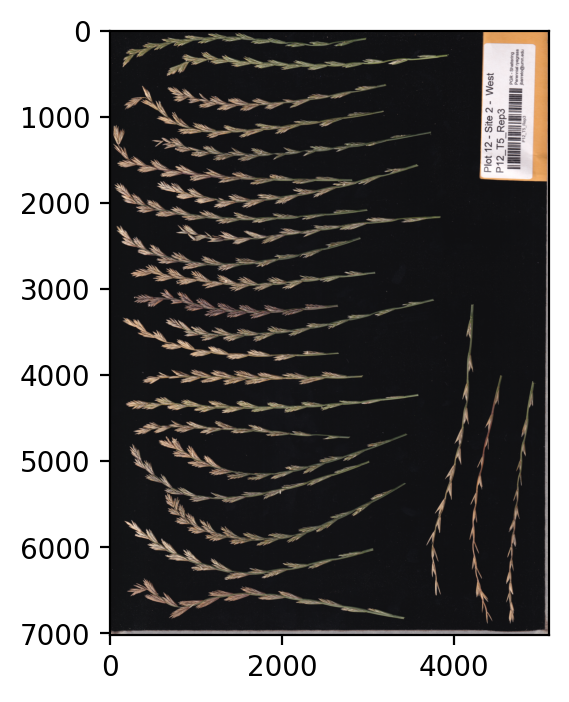

In [67]:
plt.imshow(img)

## Labeled spikelets

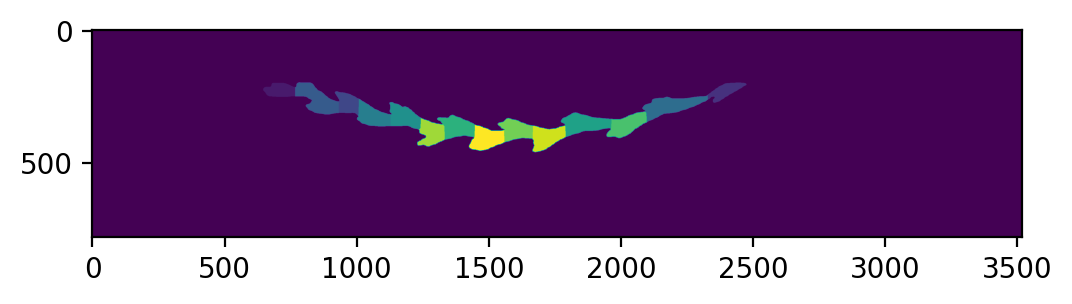

In [17]:
plt.imshow(Spikelets)

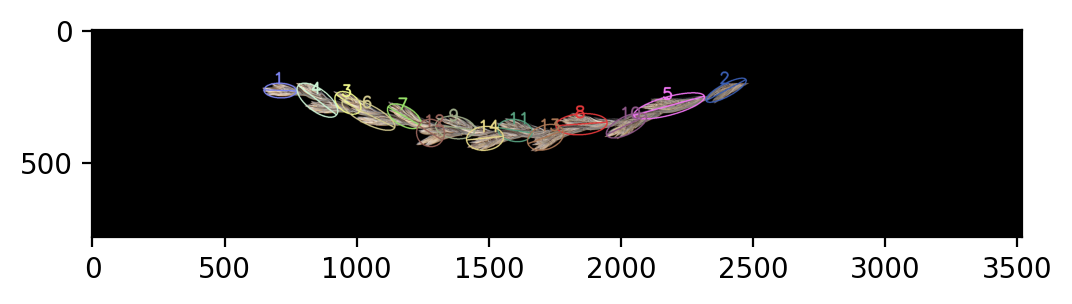

In [19]:
plt.imshow(Spikelets_Image)

In [56]:
# imports
import sys
import os
import argparse
import time
from datetime import datetime, date
# sys.path.append(".")
import SpykFunctions as SF
import pandas as pd
from pathlib import Path
from PIL import Image
from skimage import color
from skimage.measure import label
import scipy.ndimage as ndi
import numpy as np
import cv2
import signal

3448

25

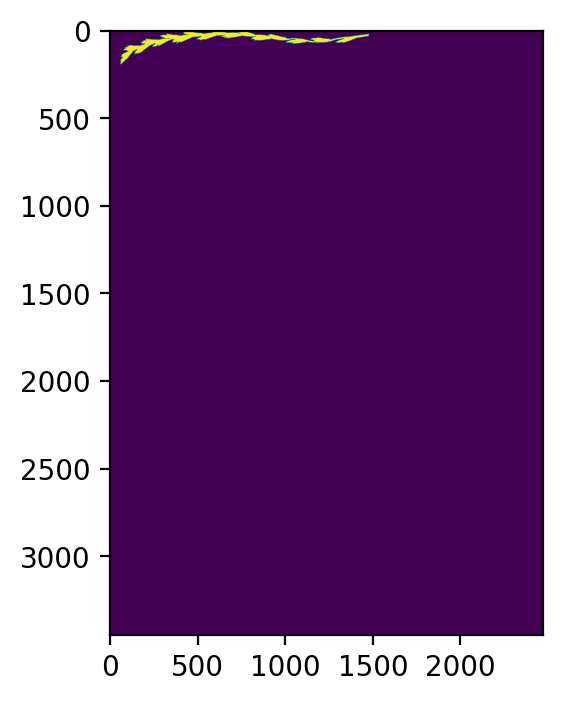

In [70]:
labeled_spks, num_spikes = label(bw0, return_num = True)
len(labeled_spks)
num_spikes

# spk = labeled_spks==Label
spk = labeled_spks==1
plt.imshow(spk)


# for Label in range(1, num_spikes+1):

#     spk = labeled_spks==Label
#     if tck_spk == True:
#         now = datetime.now().strftime("%H:%M:%S")
#         print(now +  " ---- Processing spike ", Label)
#     # Crop spike
# slice_x, slice_y = ndi.find_objects(spk)[0]
# cropped_spk = spk[slice_x, slice_y]
# cropped_rgb = rgb0[slice_x, slice_y]
# cropped_rgb = np.where(cropped_spk[..., None], cropped_rgb, 0)
# cropped_gray = color.rgb2gray(cropped_rgb)
# cropped_lab = color.rgb2lab(cropped_rgb)
# cropped_hsv = color.rgb2hsv(cropped_rgb)


In [28]:
np.amin(labeled_spks)


0

In [ ]:
# def spikelet_segm(cropped_rgb,Pad=200,MinDist=50,data_out=True,plot_ellipse=False,
#                 Numbered=False,img_out=False,plot_segmented=False):

# Add pad - improves segmentation
padded_rgb = np.pad(cropped_rgb, pad_width=[(Pad, Pad),(Pad, Pad),(0, 0)], mode='constant')
# Rescale to 10% of original
rescaled_spk = rescale(padded_rgb[...], 0.1, preserve_range=False, multichannel=True, anti_aliasing=True)
# Erosion
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(3,3))
erosion = cv2.erode(rescaled_spk,kernel,iterations = 1)
# Opening
kernel = np.ones((1,1),np.uint8)
opening = cv2.morphologyEx(erosion, cv2.MORPH_OPEN, kernel, iterations = 10)
# Resize to original
rescaled_spk2 = Image.fromarray((rescaled_spk * 255).astype(np.uint8))
rescaled_spk2 = rescaled_spk2.resize((padded_rgb.shape[1],padded_rgb.shape[0]))
# Opening
opening = np.asarray(rescaled_spk2)
# Convert rgb to gray
gray_spklts = opening @ [0.2126, 0.7152, 0.0722]
# Binarize gray (threshold may vary according to spike and background colors)
bw_spklts = gray_spklts > 50
# Get distances
distance = ndi.distance_transform_edt(bw_spklts)
# plt.imshow(-distance)
# Get max peaks
coords = peak_local_max(distance, min_distance=MinDist, labels=bw_spklts)
# Create mask
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
# Label
markers, spikelets = ndi.label(mask)
# Watershed
labels = watershed(-distance, markers, mask=bw_spklts)
labels2 = np.unique(labels[labels > 0])
# spikes shouldn't have more than 50 spikelets


if len(labels2) < 2 or len(labels2) > 50:
print("Error! Check spike segmentation!")
return

# Contours for segmented spikelets (C)
C = []
for Label in labels2:
y = labels == Label
y = y * 255
y = y.astype('uint8')
contours, hierarchy = cv2.findContours(y, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# len(contours)
contours = np.squeeze(contours)
C.append(contours)
#         plt.imshow(y)

contours = C

# Export angles, areas, and centroids. Centroids are useful to estiamte distances between spikelets
if data_out==True:

EllipsesIndex = []
EllipsesAngle = []
EllipsesLength = []
EllipsesArea = []
EllipsesCentroid = []

if plot_ellipse==True:
    OutImage = padded_rgb.copy()
    # Plot all found contours
    # OutImage = cv2.drawContours(OutImage, contours, -1, (0,0,0), 10);

ellipse_ind = 0
for c in contours:
    ellipse_ind = ellipse_ind + 1
    # Generate random colors

    random_channels = (np.random.choice(range(50,256), size=3))
    rr = int(random_channels[0])
    rg = int(random_channels[1])
    rb = int(random_channels[2])

    # Fit elipse and line
    # Source: https://stackoverflow.com/questions/62698756/opencv-calculating-orientation-angle-of-major-and-minor-axis-of-ellipse
    ellipse = cv2.fitEllipse(c)
    (xc,yc),(d1,d2),angle = ellipse
    rmajor = max(d1,d2)/2

    if angle > 90:
        angle = angle - 90
    else:
        angle = angle + 90

    xtop = xc + math.cos(math.radians(angle))*rmajor
    ytop = yc + math.sin(math.radians(angle))*rmajor
    xbot = xc + math.cos(math.radians(angle+180))*rmajor
    ybot = yc + math.sin(math.radians(angle+180))*rmajor

    ellipse_area = np.pi * d1 * d2
    ellipse_length = int(math.dist([int(xtop),int(ytop)],[int(xbot),int(ybot)]))
    EllipsesIndex.append(ellipse_ind)
    EllipsesAngle.append(angle)
    EllipsesLength.append(ellipse_length)
    EllipsesArea.append(ellipse_area)
    EllipsesCentroid.append([int(xc),int(yc)])

    if plot_ellipse==True:
        OutImage = cv2.ellipse(OutImage,ellipse,(rr,rg,rb),3);
        cv2.line(OutImage, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (rr,rg,rb), 3)

    if Numbered == True:
        cv2.putText(OutImage, str(ellipse_ind), (int(xc) - 25, int(yc) - 25),
                    cv2.FONT_HERSHEY_SIMPLEX, 2, (rr,rg,rb), 5)

# Dataframe for data
EllipsesData = pd.DataFrame({'Ellipse_Number':EllipsesIndex,
                         'Ellipse_Angle':EllipsesAngle,
                         'Ellipse_Area':EllipsesArea,
                             'Ellipse_Length':EllipsesLength,
                            'Ellipse_Centroid':EllipsesCentroid})
if img_out==True:
    return(labels, EllipsesData, OutImage)
else:
    return(labels, EllipsesData)

if plot_segmented==True and plot_ellipse==False:
plt.imshow(labels, cmap=plt.cm.nipy_spectral)
print('Detected spikelets = ', spikelets)

# # Example:
# Spikelets, EllipseData, Spikelets_Image  = spikelet_segm(
#     cropped_rgb=rgb0,Pad=200,MinDist=50,data_out=True,
#     plot_ellipse=True,Numbered=True,img_out=True,plot_segmented=False)

## Ellipses' data

In [21]:
EllipseData

,Ellipse_Number,Ellipse_Angle,Ellipse_Area,Ellipse_Length,Ellipse_Centroid
0,1,22.905899,45069.897969,186,"[373, 282]"
1,2,32.709389,51734.897241,180,"[562, 304]"
2,3,31.334106,54718.200976,194,"[749, 328]"
3,4,173.572830,58346.860885,156,"[460, 351]"
4,5,14.661606,64062.364891,187,"[1161, 370]"
5,6,13.016273,77116.553975,210,"[1410, 374]"
6,7,26.070892,48513.379163,175,"[953, 360]"
7,8,8.746750,82834.128585,276,"[2053, 387]"
8,9,160.310913,53123.924116,198,"[639, 389]"
9,10,24.290688,41530.681188,164,"[1757, 382]"


## Fitted ellipses and angles

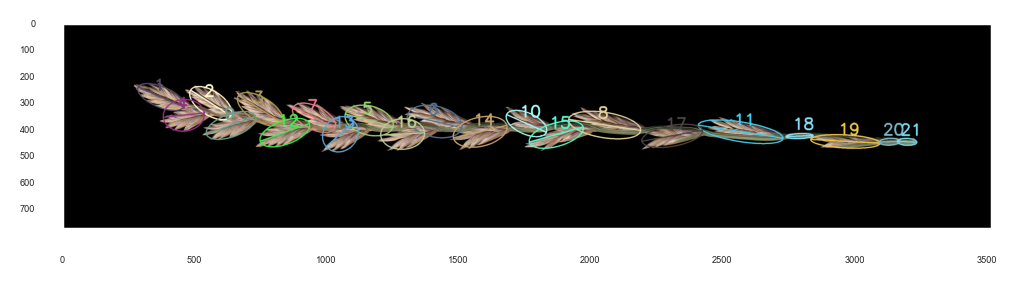

In [22]:
plt.imshow(Spikelets_Image)

## Distances Between Spikelets

The `EucDist()` requires the ellipses data from the `spikelet_segm()` function, and returns the Euclidean distance between all detected spikelets. The distance will be returned in pixels or as a proportion from the spike length (from `spk_length()`) is passed to the argument `spike_length`. 

The output is a diagonal matrix with the spikelets' (ellipses') ID as rows and columns.

A heatmap can be returned if `HeatMap=True`.

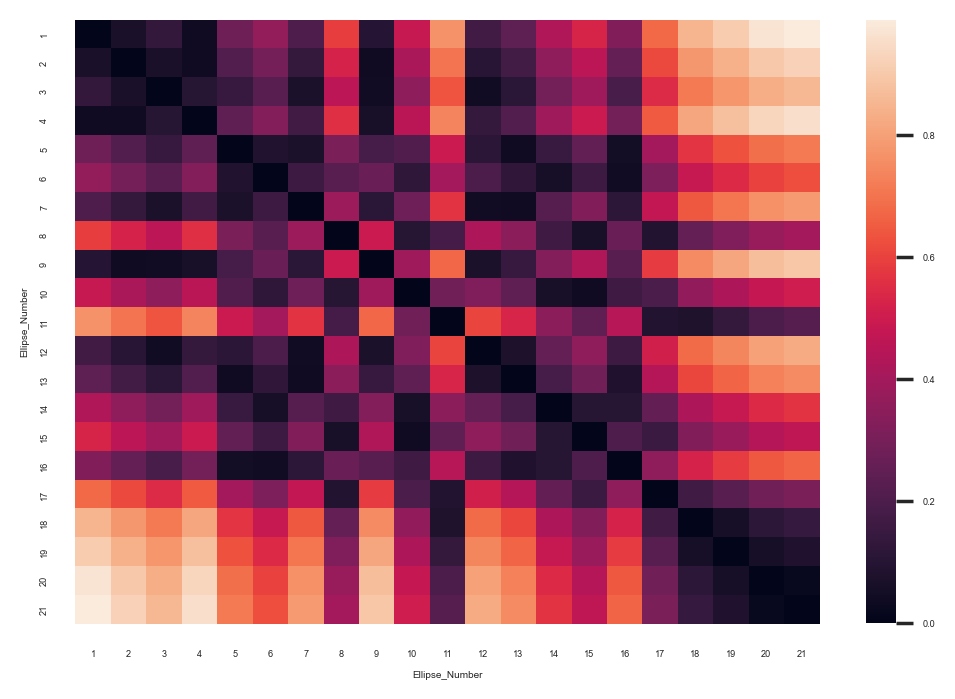

In [23]:
img0 = img[6550:6930, 180:3300, :]     # Single horizontal spike

# Segmentation
I = SF.spike_segm(img0, channel_thresh=[0,30], rgb_out=True, gray_out=True, lab_out=True, hsv_out=True, bw_out=True)
bw0 = I[4]

# Spike length
SL, length_img = SF.spk_length(bw0, Method='skel_ma', Overlay=True)

# Euclidean distance
D = SF.DistAll(EllipseData=EllipseData, HeatMap=True, spike_length=SL)

In [24]:
D

Ellipse_Number,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
Ellipse_Number,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.066437,0.132264,0.038771,0.276850,0.363503,0.204337,0.587737,0.100110,0.484500,...,0.170310,0.242410,0.424608,0.525042,0.323149,0.677897,0.845832,0.906556,0.965122,0.988146
2,0.066437,0.000000,0.065829,0.039214,0.210414,0.297096,0.137915,0.521407,0.040046,0.418136,...,0.105297,0.176320,0.358173,0.458622,0.256762,0.611521,0.779505,0.840214,0.898793,0.921821
3,0.132264,0.065829,0.000000,0.101227,0.144600,0.231354,0.072100,0.455773,0.043918,0.352460,...,0.044705,0.111104,0.292362,0.392843,0.190979,0.545811,0.713860,0.774547,0.833143,0.856176
4,0.038771,0.039214,0.101227,0.000000,0.244852,0.331801,0.172166,0.556357,0.063893,0.452992,...,0.135297,0.208532,0.392357,0.492978,0.290137,0.646160,0.814352,0.874971,0.933601,0.956643
5,0.276850,0.210414,0.144600,0.244852,0.000000,0.086953,0.072710,0.311509,0.182383,0.208143,...,0.112535,0.041853,0.147762,0.248273,0.047785,0.401349,0.569507,0.630143,0.688765,0.711805
6,0.363503,0.297096,0.231354,0.331801,0.086953,0.000000,0.159642,0.224557,0.269255,0.121191,...,0.198865,0.125772,0.061580,0.161561,0.045650,0.314462,0.482575,0.543229,0.601842,0.624880
7,0.204337,0.137915,0.072100,0.172166,0.072710,0.159642,0.000000,0.384194,0.110103,0.280831,...,0.043410,0.041083,0.220401,0.320960,0.118893,0.474059,0.642212,0.702852,0.761473,0.784512
8,0.587737,0.521407,0.455773,0.556357,0.311509,0.224557,0.384194,0.000000,0.493716,0.103367,...,0.422956,0.349376,0.164706,0.065190,0.267373,0.090525,0.258099,0.318822,0.377387,0.400415
9,0.100110,0.040046,0.043918,0.063893,0.182383,0.269255,0.110103,0.493716,0.000000,0.390371,...,0.071504,0.145012,0.329366,0.429992,0.226881,0.583260,0.751526,0.812072,0.870721,0.893768
